In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/serialized-uti-data/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-data/preprocessed_data.joblib


# Import the Libraries

In [3]:
from joblib import load

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import optuna

from sklearn.metrics import f1_score

from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load the data

In [4]:
X_train_scaled, _, y_train, _ = load(r"/kaggle/input/serialized-uti-data/preprocessed_data.joblib")

In [5]:
X_train_scaled

,Age,Color,Transparency,Glucose,Protein,pH,Specific_Gravity,WBC,RBC,Epithelial_Cells,Mucous_Threads,Amorphous_Urates,Bacteria,MALE,FEMALE
0,0.305897,0.444444,0.50,0.0,0.00,0.333333,0.570580,0.916667,0.00,0.666667,0.166667,0.000000,0.6,False,True
1,0.410768,0.000000,0.00,0.0,0.00,0.342446,0.000000,0.916667,0.00,0.166667,0.333333,0.000000,0.8,False,True
2,0.842520,0.000000,0.00,0.0,0.00,0.390418,0.643833,0.416667,0.00,0.666667,0.500000,0.000000,0.6,False,True
3,0.925286,0.555556,0.25,0.0,0.00,0.000000,0.400000,0.666667,0.00,0.333333,0.166667,0.000000,0.6,False,True
4,0.651294,0.000000,0.00,0.0,0.00,0.333333,0.400000,0.916667,0.00,0.333333,0.000000,0.000000,0.2,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,0.403825,0.555556,0.25,0.0,0.00,0.000000,1.000000,0.000000,0.00,0.666667,0.666667,0.000000,0.6,False,True
1946,0.573683,0.111111,0.25,0.0,0.25,0.333333,0.340027,0.750000,0.25,0.166667,0.000000,0.000000,0.6,False,True
1947,0.699133,0.333333,0.50,0.0,0.50,0.375206,0.700165,0.416667,0.00,0.666667,0.333333,0.166667,1.0,False,True
1948,0.527559,0.555556,0.00,0.0,0.00,0.333333,0.600000,0.000000,0.00,0.166667,0.333333,0.000000,0.0,True,False


In [6]:
y_train

2746    1
1992    1
1545    1
1914    1
449     0
       ..
378     0
2645    1
2369    1
1197    0
456     0
Name: Diagnosis, Length: 1950, dtype: int64

In [7]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_scaled, 
                                                                    y_train, 
                                                                    test_size=0.2,
                                                                    random_state=42,
                                                                   stratify = y_train)

# Hyperparameter Tuning

In [8]:
def show_study_summary(study):
    print("\033[1mBest Hyperparameters]")
    pprint(study.best_params)
    print()
    print("\033[1mAccuracy for the Best Hyperparameters]")
    print(study.best_value)
    
    optimization_history_plot = optuna.visualization.plot_optimization_history(study)
    param_importances_plot = optuna.visualization.plot_param_importances(study)
    parallel_coordinate_plot = optuna.visualization.plot_parallel_coordinate(study)
    
    optimization_history_plot.update_layout({"height":600})
    param_importances_plot.update_layout({"height":600})
    parallel_coordinate_plot.update_layout({"height":600})
    
    optimization_history_plot.show()
    param_importances_plot.show()
    parallel_coordinate_plot.show()

## Logistic Regression

In [9]:
def logreg_objective(trial):
    params = {'tol' : trial.suggest_float('tol' , 1e-6 , 1e-2, log=True),
              "C" : trial.suggest_float('C', 0.1, 1)}
    
    logreg = LogisticRegression(**params, max_iter=2000)
    
    logreg.fit(X_train_val, y_train_val)
    
    threshold = trial.suggest_float('threshold', 0.1, 1)
    
    yhat = [1 if proba[1] > threshold else 0 for proba in logreg.predict_proba(X_test_val)]
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

log_reg_study = optuna.create_study(direction = "maximize",
                            study_name = "logreg_tuning")

log_reg_study.optimize(logreg_objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:12:04,871] A new study created in memory with name: logreg_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:12:04,993] Trial 2 finished with value: 0.9397590361445783 and parameters: {'tol': 0.00018195373085865975, 'C': 0.5410061445096652, 'threshold': 0.38160002216870914}. Best is trial 2 with value: 0.9397590361445783.
[I 2023-10-26 14:12:05,004] Trial 3 finished with value: 0.806060606060606 and parameters: {'tol': 0.0017247735913148159, 'C': 0.3369978682843294, 'threshold': 0.876805811596919}. Best is trial 2 with value: 0.9397590361445783.
[I 2023-10-26 14:12:05,000] Trial 1 finished with value: 0.7951070336391438 and parameters: {'tol': 0.0003737758180903886, 'C': 0.5425738849202502, 'threshold': 0.9014648238746283}. Best is trial 2 with value: 0.9397590361445783.
[I 2023-10-26 14:12:05,015] Trial 0 finished with value: 0.9263657957244656 and parameters: {'tol': 1.5250779456223977e-05, 'C': 0.5986954948415557, 'threshold': 0.18907170371511017}. Best is trial 2 with value: 0.9397590361445783.
[I 2023-10-26 14:12:05,124] Trial 4 finished with value: 0.25112107623318386 a

In [10]:
show_study_summary(log_reg_study)

Best Hyperparameters]
{'C': 0.4159573552401913,
 'threshold': 0.5797917659499351,
 'tol': 4.854384582041304e-05}

Accuracy for the Best Hyperparameters]
0.9582309582309582


## Random Forest

In [11]:
def forest_objective(trial):
    params = {"n_estimators" : trial.suggest_int('n_estimators', 20, 150),
              "max_depth" : trial.suggest_int('max_depth', 10, 30),
             "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2", None, 2]),
             "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])}
    
    random_forest = RandomForestClassifier(**params)
    
    random_forest.fit(X_train_val, y_train_val)
    
    yhat = random_forest.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

forest_study = optuna.create_study(direction = "maximize",
                            study_name = "forest_tuning")

forest_study.optimize(forest_objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:12:14,687] A new study created in memory with name: forest_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:12:15,688] Trial 0 finished with value: 0.9798994974874372 and parameters: {'n_estimators': 69, 'max_depth': 19, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-10-26 14:12:15,729] Trial 1 finished with value: 0.9774436090225563 and parameters: {'n_estimators': 67, 'max_depth': 22, 'max_features': 2, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-10-26 14:12:16,265] Trial 4 finished with value: 0.9798994974874372 and parameters: {'n_estimators': 42, 'max_depth': 25, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9798994974874372.
[I 2023-10-26 14:12:16,520] Trial 3 finished with value: 0.9848484848484849 and parameters: {'n_estimators': 124, 'max_depth': 19, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 3 with value: 0.9848484848484849.
[I 2023-10-26 14:12:16,545] Trial 2 finished with value: 0.9774436090225563 and parameters: {'n_estim

In [12]:
show_study_summary(forest_study)

Best Hyperparameters]
{'criterion': 'gini',
 'max_depth': 19,
 'max_features': 'log2',
 'n_estimators': 124}

Accuracy for the Best Hyperparameters]
0.9848484848484849


## Support Vector Machine


In [13]:
def SVC_objective(trial):
    params = {"C" : trial.suggest_float("C", 0.1, 1, log=True),
              "kernel" : trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])}
    
    SVC_MODEL = SVC(**params)
    
    SVC_MODEL.fit(X_train_val, y_train_val) 
    
    yhat = SVC_MODEL.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

SVM_SVC_study = optuna.create_study(direction = "maximize",
                            study_name = "SVM_tuning")

SVM_SVC_study.optimize(SVC_objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:12:54,908] A new study created in memory with name: SVM_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:12:54,984] Trial 2 finished with value: 0.982367758186398 and parameters: {'C': 0.6796450912773079, 'kernel': 'poly'}. Best is trial 2 with value: 0.982367758186398.
[I 2023-10-26 14:12:54,986] Trial 1 finished with value: 0.9701492537313433 and parameters: {'C': 0.16951903576456084, 'kernel': 'poly'}. Best is trial 2 with value: 0.982367758186398.
[I 2023-10-26 14:12:54,999] Trial 0 finished with value: 0.9774436090225563 and parameters: {'C': 0.6932082966397548, 'kernel': 'rbf'}. Best is trial 2 with value: 0.982367758186398.
[I 2023-10-26 14:12:55,003] Trial 3 finished with value: 0.972568578553616 and parameters: {'C': 0.1938765072152626, 'kernel': 'poly'}. Best is trial 2 with value: 0.982367758186398.
[I 2023-10-26 14:12:55,037] Trial 4 finished with value: 0.9466019417475728 and parameters: {'C': 0.26804488175360663, 'kernel': 'linear'}. Best is trial 2 with value: 0.982367758186398.
[I 2023-10-26 14:12:55,053] Trial 5 finished with value: 0.9466019417475728 and

In [14]:
show_study_summary(SVM_SVC_study)

Best Hyperparameters]
{'C': 0.6796450912773079, 'kernel': 'poly'}

Accuracy for the Best Hyperparameters]
0.982367758186398


## XGBoost

In [15]:
def XGB_objective(trial):
    params = {
        "objective": "binary:logistic",
        "booster": "gbtree",
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.1, log=True)}

    XGB_model = xgb.XGBClassifier(**params)
    
    XGB_model.fit(X_train_val, y_train_val) 
    
    yhat = XGB_model.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

XGB_study = optuna.create_study(direction = "maximize",
                            study_name = "XGB_tuning")

XGB_study.optimize(XGB_objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:12:58,161] A new study created in memory with name: XGB_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:12:58,886] Trial 0 finished with value: 0.9773299748110831 and parameters: {'reg_alpha': 0.5293031894913575, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.0009403233080758364}. Best is trial 0 with value: 0.9773299748110831.
[I 2023-10-26 14:12:58,894] Trial 2 finished with value: 0.9774436090225563 and parameters: {'reg_alpha': 0.730674185166034, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0422870719103485}. Best is trial 2 with value: 0.9774436090225563.
[I 2023-10-26 14:12:59,357] Trial 5 finished with value: 0.9773299748110831 and parameters: {'reg_alpha': 0.6821680839643269, 'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.00011147914620314651}. Best is trial 2 with value: 0.9774436090225563.
[I 2023-10-26 14:13:00,924] Trial 6 finished with value: 0.9773299748110831 and parameters: {'reg_alpha': 0.17900718294657178, 'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.00027346004561528184}. Best is trial 2 with value: 0.9774436090

In [16]:
show_study_summary(XGB_study)

Best Hyperparameters]
{'learning_rate': 0.05059504122772722,
 'max_depth': 5,
 'n_estimators': 400,
 'reg_alpha': 0.5059724124656714}

Accuracy for the Best Hyperparameters]
0.9798994974874372


## Light GBM

In [17]:
def lightgmb_objective(trial):
    params = {
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200, step=10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=50),
        "max_depth": trial.suggest_categorical("max_depth", [-1, 3, 4, 5]),
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.1, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 0.9)
    }
    
    lgbm_model = lgb.LGBMClassifier(**params)
    
    lgbm_model.fit(X_train_val, y_train_val) 
    
    yhat = lgbm_model.predict(X_test_val)
    
    f1_score_ = f1_score(y_test_val, yhat)
    
    return f1_score_

lgbm_study = optuna.create_study(direction = "maximize",
                            study_name = "lgbm_tuning")

lgbm_study.optimize(lightgmb_objective,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:14:01,139] A new study created in memory with name: lgbm_tuning


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:14:02,011] Trial 1 finished with value: 0.9798994974874372 and parameters: {'boosting_type': 'goss', 'num_leaves': 170, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.062407929320143475, 'reg_alpha': 0.6168738024159464}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-10-26 14:14:02,155] Trial 2 finished with value: 0.9774436090225563 and parameters: {'boosting_type': 'goss', 'num_leaves': 130, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.021544409424730116, 'reg_alpha': 0.7279102875395193}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-10-26 14:14:02,506] Trial 3 finished with value: 0.975 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 140, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.010398454181218325, 'reg_alpha': 0.5397263908741301}. Best is trial 1 with value: 0.9798994974874372.
[I 2023-10-26 14:14:02,528] Trial 0 finished with value: 0.9748743718592966 and parameters: {'boosting_type': 'goss', 'num_leav

In [18]:
show_study_summary(lgbm_study)

Best Hyperparameters]
{'boosting_type': 'goss',
 'learning_rate': 0.062407929320143475,
 'max_depth': -1,
 'n_estimators': 200,
 'num_leaves': 170,
 'reg_alpha': 0.6168738024159464}

Accuracy for the Best Hyperparameters]
0.9798994974874372


## ANN: Multi-layer Perceptron

## Load the data using Pytorch

In [19]:
class UTIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx, :][:-1].values.astype("float32").reshape((self.df.columns.__len__()-1, 1))
        y = self.df.iloc[idx, :][-1:].values.astype("long").reshape((1, 1))
        
        if transform:
            x = transform(x)
            y = transform(y)
            
        return (x, y)

In [20]:
transform = transforms.ToTensor()

X_train_scaled_reset = X_train_scaled.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

df = pd.concat([X_train_scaled_reset, y_train_reset], axis=1)

data = UTIDataset(df, transform)

In [21]:
# set the random seed
torch.manual_seed(42)
np.random.seed(42)

In [22]:
train_set_torch, val_set_torch, test_set_torch = torch.utils.data.random_split(data, [0.6, 0.2, 0.2])

In [23]:
batch_size = 15 # batch size

train_loader = DataLoader(train_set_torch, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_set_torch, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set_torch, batch_size=batch_size, shuffle=False)

## MLP Architecture

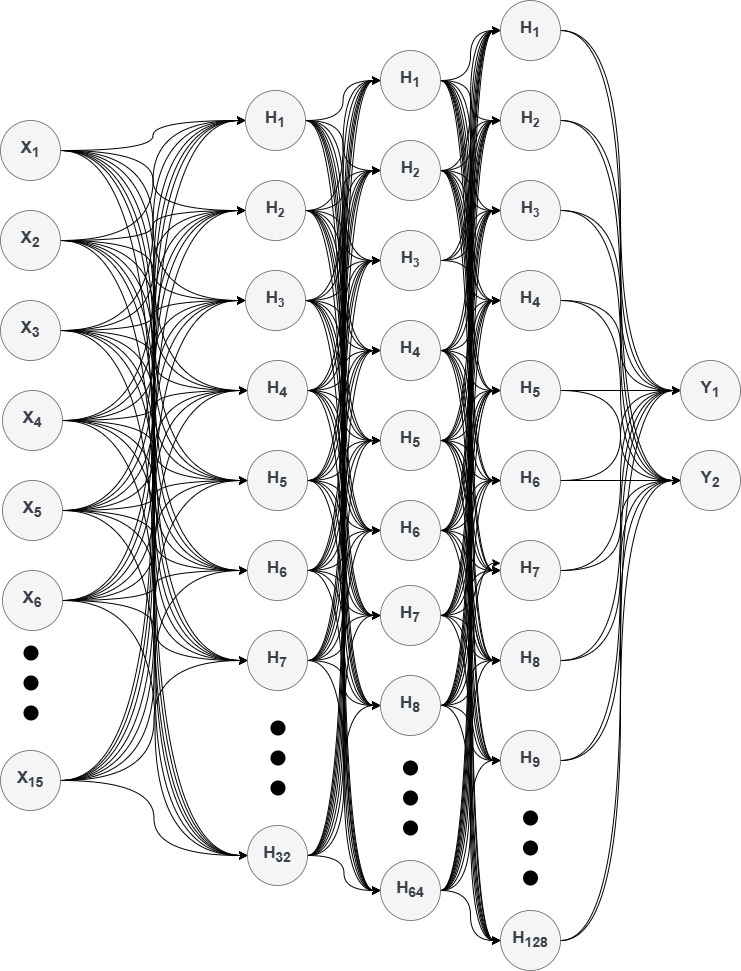

In [24]:
class ClassifierNN(nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        
        self.activation_function = activation_function
        
        self.fcn1 = nn.Linear(15, 32) # 7 is the number of features, 64 user defined
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2) # 3 is the number of targets
        
    def forward(self, x):
        x = x.view(-1, 15)
        
        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))
        
        x = self.fcn4(x)
        
        return x

In [25]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [26]:
def tune_NN(trial, train_loader_, val_loader_):
    """
      Tune a Convolutional Neural Network (CNN) using various hyperparameters.

      Parameters
      ----------
      trial : optuna.Trial
          An Optuna trial object used for hyperparameter optimization.

      train_loader_ : torch.utils.data.DataLoader
          DataLoader for the training dataset.

      val_loader_ : torch.utils.data.DataLoader
          DataLoader for the validation dataset.

      Returns
      -------
      float
          The accuracy of the tuned CNN model on the validation dataset.

      Notes
      -----
      This function performs hyperparameter optimization for a CNN model using the Optuna library.

      The hyperparameters that can be optimized are:
      - Kernel size for convolutional layers
      - Choice of optimizer (SGD, Adam, or RMSprop)
      - Activation functions (ReLU, Leaky ReLU, or Tanh)
      - Learning rate
      - Number of training epochs

      The CNN model is trained and tuned using the specified hyperparameters, and its accuracy on the
      validation dataset is returned.

      Examples
      --------
      >>> import optuna
      >>> study = optuna.create_study(direction='maximize')
      >>> study.optimize(tune_CNN, n_trials=10, args=(train_loader, val_loader))
      >>> best_trial = study.best_trial
      >>> best_accuracy = best_trial.value
      >>> best_params = best_trial.params
      >>> print(f"Best accuracy: {best_accuracy}")
      >>> print(f"Best hyperparameters: {best_params}")
    """

    optimizers_ = trial.suggest_categorical("optimizer", ["SGD", "Adam", "RMSprop"])
    activation_functions = trial.suggest_categorical("activation function", [F.relu, F.leaky_relu, F.tanh])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    epochs = trial.suggest_int("epochs", 10, 50)

    NN_model = ClassifierNN(activation_functions)

    NN_model = NN_model.to("cuda")

    criterion = nn.CrossEntropyLoss()

    if optimizers_ == "SGD":
        optimizer = optim.SGD(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "Adam":
        optimizer = optim.Adam(NN_model.parameters(), lr=learning_rate)
    elif optimizers_ == "RMSprop":
        optimizer = optim.RMSprop(NN_model.parameters(), lr=learning_rate)

    for _ in range(epochs):
        running_loss = 0.0

        for x_train, y_train in train_loader_:
            x_train = x_train.to("cuda")
            y_train = y_train.to("cuda")

            optimizer.zero_grad()
            outputs = NN_model(x_train)
            
            y_train = y_train.flatten()

            loss = criterion(outputs, y_train)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader_:
            val_X = val_X.to("cuda")
            val_y = val_y.to("cuda")

            outputs = NN_model(val_X)

            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend([arr.flatten()[0] for arr in val_y.cpu().numpy()])
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate the F1-score
    f1 = f1_score(true_labels, predicted_labels)

    torch.cuda.empty_cache()

    return f1

In [27]:
study = optuna.create_study(direction="maximize")

params = {"train_loader_":train_loader,
         "val_loader_":val_loader}

study.optimize(lambda trial: tune_NN(trial, **params),
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-10-26 14:14:38,960] A new study created in memory with name: no-name-afc8ac35-59cc-41fd-bb5b-125d7de0265c


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-26 14:15:14,197] Trial 2 finished with value: 0.9516539440203563 and parameters: {'optimizer': 'SGD', 'activation function': <function leaky_relu at 0x7a73a143b7f0>, 'learning_rate': 0.05198506605120426, 'epochs': 14}. Best is trial 2 with value: 0.9516539440203563.
[I 2023-10-26 14:15:21,521] Trial 3 finished with value: 0.958974358974359 and parameters: {'optimizer': 'Adam', 'activation function': <function leaky_relu at 0x7a73a143b7f0>, 'learning_rate': 0.00014594823016047818, 'epochs': 11}. Best is trial 3 with value: 0.958974358974359.
[I 2023-10-26 14:15:23,254] Trial 0 finished with value: 0.6505190311418685 and parameters: {'optimizer': 'SGD', 'activation function': <function leaky_relu at 0x7a73a143b7f0>, 'learning_rate': 9.79499863111513e-05, 'epochs': 20}. Best is trial 3 with value: 0.958974358974359.
[I 2023-10-26 14:16:13,506] Trial 1 finished with value: 0.9842105263157895 and parameters: {'optimizer': 'Adam', 'activation function': <function relu at 0x7a73a14

In [28]:
show_study_summary(study)

Best Hyperparameters]
{'activation function': <function relu at 0x7a73a143b400>,
 'epochs': 37,
 'learning_rate': 0.0006235522965861906,
 'optimizer': 'Adam'}

Accuracy for the Best Hyperparameters]
0.9868073878627969
